# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
!pip install -q bentoml tensorflow matplotlib

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [4]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        with tf.device("cpu:0"):  # map_fn has issues on GPU https://github.com/tensorflow/tensorflow/issues/28007
            inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## Build the image preprocessing

Ankle boot


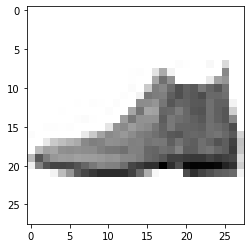

In [5]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')
plt.imsave("test.png", 255.0 - d_test_img, cmap='gray')

# read bytes
with open("test.png", "rb") as f:
    img_bytes = f.read()

# verify saved image
assert tf.reduce_mean(FashionMnist.image_bytes2tensor(tf.constant([img_bytes])) - d_test_img) < 0.01

## Train the model


In [9]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=50)

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/sample - loss: 0.5019 - accuracy: 0.8245
Epoch 2/50
60000/60000 [==============================] - 3s 51us/sample - loss: 0.3775 - accuracy: 0.8638
Epoch 3/50
60000/60000 [==============================] - 3s 53us/sample - loss: 0.3397 - accuracy: 0.8765
Epoch 4/50
60000/60000 [==============================] - 3s 52us/sample - loss: 0.3135 - accuracy: 0.8852
Epoch 5/50
60000/60000 [==============================] - 3s 52us/sample - loss: 0.2946 - accuracy: 0.8908
Epoch 6/50
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2792 - accuracy: 0.8968
Epoch 7/50
60000/60000 [==============================] - 3s 52us/sample - loss: 0.2695 - accuracy: 0.9012
Epoch 8/50
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2575 - accuracy: 0.9033
Epoch 9/50
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2478 - accuracy: 0.9072
Epoch 10/50
60

## Model inference test run

In [10]:
predict = model.predict_image(tf.constant([img_bytes]))
klass = tf.argmax(predict, axis=1)
[class_names[c] for c in klass]

['Ankle boot']

And the model predicts a label as expected.

# Create BentoService class

In [18]:
%%writefile tensorflow_fashion_mnist.py

import bentoml
import tensorflow as tf

from bentoml.artifact import TensorflowSavedModelArtifact
from bentoml.adapters import TfTensorInput


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(input=TfTensorInput(), batch=True)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[c] for c in output_classes]

Overwriting tensorflow_fashion_mnist.py


In [19]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()

[2020-07-28 15:36:46,482] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /tmp/bentoml-temp-8dcup0pe/FashionMnistTensorflow/artifacts/model_saved_model/assets
[2020-07-28 15:36:58,212] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry points to BentoML.egg-info/entry_points.txt
writing requirements to BentoML.egg-info/requires.txt
writing top-level names to BentoML.egg-info/top_level.txt
reading manifest file 'BentoML.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.3+42.gb8d36b6
creating BentoML-0.8.3+42.gb8d36b6/BentoML.egg-info
creating BentoML-0.8.3+42.gb8d36b6/bentoml
creating BentoML-0.8.3+42.gb8d36b6/bentoml/adapters
creating BentoML-0.8.3+42.gb8d36b6/bentoml/artifact
creating BentoML-0.8.3+42.gb8d36b6/bentoml/cli
creating BentoML-0.8.3+42.gb8d36b6/bentoml/clipper
creating BentoML-0.8.3+42.gb8d36b6/bentoml/configuration
creating BentoML-0.8.3+42.gb8d36b6/bentoml/configuration/__pycache__
creating BentoML-0.8.3+42.gb8d36b6/bentoml/handlers
creating BentoML-0.8.3+42.gb8d36b6/bentoml/marshal
creating BentoML-0.8.3+42.gb8d36b6/bentoml/saved_bundle
creating BentoML-0.8.3+42.gb8d36b6/bentoml/server
creating BentoML-0.8.3+42.gb8d36b6/bentoml/utils
creating BentoML-0.8.3+42.gb8d36b6/bentoml/yatai
creating BentoML-0.8.3+42.gb8d36b6/bentoml/yatai/client
creating BentoML-0.8.3+42.gb8d36b6/bentoml/yatai/deployment
creating BentoML-0.8.3+42.gb8d36b6/bentoml/yatai/dep

## Use BentoService with BentoML CLI

**`bentoml get <BentoService Name>` list all of BentoService's versions**

In [ ]:
!bentoml get FashionMnistTensorflow

**`bentoml get <BentoService name>:<bentoService version>` display detailed information of the specific BentoService version**

In [7]:
!bentoml get FashionMnistTensorflow:latest 

[2020-07-28 15:41:15,592] INFO - Getting latest version FashionMnistTensorflow:20200728153646_C57052
{
  "name": "FashionMnistTensorflow",
  "version": "20200728153646_C57052",
  "uri": {
    "type": "LOCAL",
    "uri": "/home/bentoml/bentoml/repository/FashionMnistTensorflow/20200728153646_C57052"
  },
  "bentoServiceMetadata": {
    "name": "FashionMnistTensorflow",
    "version": "20200728153646_C57052",
    "createdAt": "2020-07-28T07:36:59.200032Z",
    "env": {
      "condaEnv": "name: bentoml-FashionMnistTensorflow\nchannels:\n- defaults\ndependencies:\n- python=3.6.10\n- pip\n",
      "pipDependencies": "tensorflow\nbentoml==0.8.3\nnumpy\npillow",
      "pythonVersion": "3.6.10",
      "dockerBaseImage": "bentoml/model-server:0.8.3"
    },
    "artifacts": [
      {
        "name": "model",
        "artifactType": "TensorflowSavedModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "inputType": "TfTensorInput",
        "docs": "BentoService inf

**Serve bentoml REST server locally**

In [2]:
!bentoml serve FashionMnistTensorflow:latest

[2020-07-28 15:39:14,893] INFO - Getting latest version FashionMnistTensorflow:20200728153646_C57052
[2020-07-28 15:39:14,893] INFO - Starting BentoML API server in development mode..
[2020-07-28 15:39:16,013] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-07-28 15:39:16,036] WARNING - Saved BentoService bundle version mismatch: loading BentoService bundle create with BentoML version 0.8.3, but loading from BentoML version 0.8.3+42.gb8d36b6
2020-07-28 15:39:17.628512: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-28 15:39:17.643972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

## Query REST API with python

In [8]:
import base64
import json
import requests

with open("test.png", "rb") as f:
    img_bytes = f.read()
img_b64 = base64.b64encode(img_bytes).decode()


headers = {"content-type": "application/json"}
data = json.dumps(
       {"instances": [{"b64": img_b64}]}
)
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

json_response = requests.post(f'http://localhost:5000/predict', data=data, headers=headers)
print(json_response)
print(json_response.text)

Data: {"instances": [{"b64": "iVBORw0KGgoAAAANSUhEUgAAAB ... ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII="}]}
<Response [200]>
["Ankle boot"]


# Use BentoService as PyPI package

`pip install $SAVED_PATH` also installs a CLI tool for accessing the BentoML service

In [10]:
!pip install -q {saved_path}

In [11]:
!FashionMnistTensorflow --help

Usage: FashionMnistTensorflow [OPTIONS] COMMAND [ARGS]...

  BentoML CLI tool

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  containerize        Containerizes given Bento into a ready-to-use Docker
                      image

  info                List APIs
  install-completion  Install shell command completion
  open-api-spec       Display OpenAPI/Swagger JSON specs
  run                 Run API function
  serve               Start local dev API server
  serve-gunicorn      Start production API server


### Run 'predict' api with json data:

In [13]:
!echo '{\"instances\":[{\"b64\":\"'$(base64 test.png)'\"}]}' > test.json
!cat test.json | xargs -I {} FashionMnistTensorflow run predict --input={}

2020-07-28 15:45:44.309676: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-28 15:45:44.324141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-28 15:45:44.324506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2020-07-28 15:45:44.324699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-28 15:45:44.326113: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-07-28 15:45:44.327389: I tensorflow/stream_executor/platform/

## Build realtime prediction service in docker with BentoService

In [14]:
!docker build --quiet -t tensorflow2-fashion-mnist {saved_path}

sha256:dbf669648a388423aedf26c2124c31299c5453fc8a5740ad15bddafe22fda5e5


In [15]:
!docker run -p 5000:5000 tensorflow2-fashion-mnist --workers 1 --enable-microbatch

[2020-07-28 07:51:49,529] INFO - Starting BentoML API server in production mode..
[2020-07-28 07:51:49,927] INFO - Running micro batch service on :5000
[2020-07-28 07:51:49 +0000] [12] [INFO] Starting gunicorn 20.0.4
[2020-07-28 07:51:49 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-07-28 07:51:49 +0000] [12] [INFO] Listening at: http://0.0.0.0:5000 (12)
[2020-07-28 07:51:49 +0000] [12] [INFO] Using worker: aiohttp.worker.GunicornWebWorker
[2020-07-28 07:51:49 +0000] [1] [INFO] Listening at: http://0.0.0.0:37381 (1)
[2020-07-28 07:51:49 +0000] [1] [INFO] Using worker: sync
[2020-07-28 07:51:49 +0000] [13] [INFO] Booting worker with pid: 13
[2020-07-28 07:51:49 +0000] [14] [INFO] Booting worker with pid: 14
[2020-07-28 07:51:49,954] WARNING - Using BentoML not from official PyPI release. In order to find the same version of BentoML when deplying your BentoService, you must set the 'core/bentoml_deploy_version' config to a http/git location of your BentoML fork, e.g.: 'bentoml_deploy_

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this demo, we are going to deploy to AWS Sagemaker

In [ ]:
bento_service_tag = f'{bento_svc.name}:{bento_svc.version}'
print(bento_service_tag)

In [ ]:
!bentoml sagemaker deploy first-tf-fashion -b {bento_service_tag} --api-name predict --verbose

In [ ]:
!bentoml sagemaker get first-tf-fashion

In [ ]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name dev-first-tf-fashion --content-type 'application/json' \
--body "{\"instances\":[{\"b64\":\"iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA2dJREFUSIntlk9L60oYh59Mp43axJoiVj2KboSuXPoJXLkQ/Fx+Ahe6ceFG3CtdWlFcFf9RKlhFatpSbWuaNLHJnIW3OR7ugcu9BzxccGAgZCbv887v/b1JNKWU4hOH+EzYF/AL+OeBYRjysct83wegUqn8HlApRRRFADw+PrK/v4/jOCQSCTRNi/fpug7AwcHB7wEBhHh/9Pj4mGKxyM7Ozt/2NBoNdnd3MU0zvif/CywMQ6SUnJ+fc3NzQy6Xo1KpsLGxgWVZ9Pt9FhYWaLVadLtd5ubmfiT6b2FRFCGlxHEc9vf3UUrR7/d5fX1FKRXPq6srpJRYlsVgMPhn4LD4URTF12EYxlJubW2Ry+WYnp7G8zz6/T65XC6uYzqdRtd1fN+n2+3iOM6vgcPgw+ILIdA0jTAMSSQSAOzt7WHbNtPT0xiGQbvdJpvNMjU1RTKZJAxD3t7e4ni9Xo/b29tfA4egKIoYDAZxAkPYzs4OpVKJ+fl5Wq0W7XYbz/PIZDK8vr6iaRpjY2Mkk0mUUnG8w8ND4INphjbXNA2lFEKIWD6AWq3GwcEBnuextLSE4zj4vk+r1SKVSqFpGq7rxsnpuo4QgnQ6jRCCYrH4DhxK9TH4MKtms0m1WqVcLvP09EQqlWJ8fJx2u0232+Xt7Q3f9xFCUK1WGQwGTExMkEwmEUKglGJ0dJQwDDEMg8vLS+RQqnq9zv39Pb1ej16vh+d53N3d4bouUkpM0ySKIjqdDp7nIaXEdV1GR0fRdZ0gCJidnaXT6eC6LpZl4TgOLy8vpNNpbNvm+fn5XdJCoUCtVkNKSbPZjA0yBDmOg23bKKXwfR/LsoiiCMdxCMOQdDqNYRhkMhkajUaslGVZCCHwPI8gCJBSIo+Ojtje3iafzzMzMxOfJJVKxe9G0zQJggAhRNxvnuehaRpRFGHbNvV6nevra4IgIAxDAAzDwHVddF3HMAympqaQKysrnJ6ecnFx8aOwf50sm82SzWbJZDIEQYBSilarRblcxnVdut0umqZRKpVYXl5mcXGRQqGA7/uxD6SUfPv2DdM031388SfKcRzOzs4ol8ucnJzQbDZ/atqhA7PZLPl8ntXVVdbW1hgZGYnX19fXeXh4YHJyEtM0MU0TKSW6rrO5ufkz8DPG//sD/AX8I8DvdgnOxdB4B1wAAAAASUVORK5CYII=\"}]}" \
output.json && cat output.json

In [ ]:
!bentoml sagemaker delete first-tf-fashion --force